### Full Pipeline: Audio Segmentation & Truth Verification
1. Segmenting long story audio files into 30-second clips  
2. Extracting MFCC features  
3. Splitting into train and test sets  
4. Training a classification model to detect truthful stories  
5. Evaluating model performance

In [1]:
# Importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa
from sklearn.model_selection import train_test_split

# 👇 Project root added to sys.path 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


# Local modules 
from src.features import extract_features_batch
from src.segmenter2 import segment_audio_files
from src.features import extract_features




##### from src.features import extract_features_batch


### Step 1 — Segmenting Audio Files and Creating Combined Metadata Including Labels

Audio recordings of any length are automatically segmented into fixed 30-second chunks.

- Each segment is saved in the `segments/` folder.
- Metadata for all segments, including file paths, language, and associated labels (e.g., deceptive or true), is stored in `segment_metadata_enriched.csv`.


In [2]:

df = segment_audio_files(
    csv_path="../data/MLEndDD_story_attributes_small.csv",
    input_audio_dir="../data/MLEndDD_stories_small",
    output_segment_dir="../data/segmented"
)


df.to_csv("../data/segment_metadata_enriched.csv", index=False)
df.head()
csv_path = "../data/segment_metadata_enriched.csv"


df = pd.read_csv(csv_path)
print("Loaded columns:", df.columns.tolist())
print("First row:", df.iloc[0])


Segmenting audio: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]

Loaded columns: ['original_file', 'segment_id', 'segment_path', 'duration', 'label', 'Language', 'Story_type']
First row: original_file                           00001.wav
segment_id                                      1
segment_path     ../data/segmented/00001_seg1.wav
duration                                       30
label                                           0
Language                                    Hindi
Story_type                        deceptive_story
Name: 0, dtype: object


 

### Step 2 — Stratified Train/Test Split 

To ensure a balanced and unbiased evaluation, we perform a **stratified split** at the level of original audio files. 

This means:
- We first group all segments by their `original_file` and assign each file a single label (assuming all segments from one file share the same label).
- Then we use `train_test_split()` with `stratify` to maintain the **same proportion of true vs. false stories** in both the training and test sets.

**Why stratify?**
- It prevents class imbalance .
- It ensures that both classes are equally represented in model evaluation.

**Why split by file (not by segment)?**
- To avoid **data leakage**, where different segments from the same file could end up in both training and test sets.
- This ensures the model doesn't "memorize" parts of the same story by the same speaker across sets


In [3]:

# Step 1: Get file-level label mapping
file_labels = df.groupby('original_file')['label'].first().reset_index()

# Step 2: Split files into stratified train/test
train_files, test_files = train_test_split(
    file_labels,
    test_size=0.15,
    stratify=file_labels['label'],
    random_state=42
)

# Step 3: Select segments by file
train_df = df[df['original_file'].isin(train_files['original_file'])]
test_df = df[df['original_file'].isin(test_files['original_file'])]

# Step 4: Check balance
print("Train label balance:")
print(train_df['label'].value_counts())
print("\nTest label balance:")
print(test_df['label'].value_counts())



# Additional step: Save train and test DataFrames to CSV files
train_df.to_csv("../data/train_segments.csv", index=False)
test_df.to_csv("../data/test_segments.csv", index=False)



Train label balance:
label
1    183
0    170
Name: count, dtype: int64

Test label balance:
label
1    36
0    31
Name: count, dtype: int64


### Step 3 — Feature Extraction

In this step, we extract numerical features from each audio segment.

- **Training Set:** Features are extracted with augmentation (e.g., pitch/tempo shifts) to improve generalization.
- **Test Set:** Features are extracted without augmentation to reflect real inference conditions.
- Any audio files that fail during extraction are logged, and for test data, a zero-vector is used as a fallback to maintain array shape integrity.


In [4]:
# =======================
# 🚀 Feature Extraction
# =======================

X_train, y_train = [], []

# -----------------------
# 📌 Train Set Extraction
# -----------------------
# Loop through each training row and extract augmented features
for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Extracting Train Features"):
    try:
        feats = extract_features(row["segment_path"], augment=True)  # multiple versions per sample
        X_train.extend(feats)
        y_train.extend([row["label"]] * len(feats))
    except Exception as e:
        print(f"[Train Error] {row['segment_path']}: {e}")

# Ensure features were extracted
if len(X_train) == 0:
    raise ValueError("No training features extracted. Check segment paths or function logic.")

# Convert to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# ----------------------
# 🧪 Test Set Extraction
# ----------------------
X_test = []

# Extract only the original (non-augmented) features for test set
for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Extracting Test Features"):
    try:
        feats = extract_features(row["segment_path"], augment=False)
        X_test.append(feats[0])  # Take only the original version
    except Exception as e:
        print(f"[Test Error] {row['segment_path']}: {e}")
        # Append dummy zero vector in case of error to maintain shape (only safe if X_train exists)
        X_test.append(np.zeros(X_train.shape[1]))

X_test = np.array(X_test)
y_test = test_df["label"].values


Extracting Test Features: 100%|██████████| 67/67 [00:35<00:00,  1.87it/s]


In [7]:
# Print the shape of training feature matrix and label array
print("Train shape:", X_train.shape, y_train.shape)

# Print the shape of test feature matrix and label array
print("Test shape:", X_test.shape, y_test.shape)

# Display the length of a single feature vector (should match number of extracted features)
print("Sample feature vector (len):", len(X_train[0]))


Train shape: (1412, 62) (1412,)
Test shape: (67, 62) (67,)
Sample feature vector (len): 62


### Step 4 — Feature Scaling, Catboostmodel Model Training

Before training the model, we normalize all features using **StandardScaler** to ensure that each feature contributes equally. 

- `StandardScaler()` transforms each feature to have **zero mean** and **unit variance**.
- We fit the scaler on the training data (`X_train`) and apply the same transformation to the test data (`X_test`) to maintain consistency.
- After scaling, the model is trained using the scaled training features and their corresponding labels.


In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#model.fit(X_train_scaled, y_train)



In [35]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    learning_rate=0.005,
    depth=6,
    iterations=300,
    verbose=0,
    random_state=42
)

# Then train
model.fit(X_train_scaled, y_train)


In [36]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6268656716417911
F1-score: 0.6376811594202898
              precision    recall  f1-score   support

           0       0.59      0.65      0.62        31
           1       0.67      0.61      0.64        36

    accuracy                           0.63        67
   macro avg       0.63      0.63      0.63        67
weighted avg       0.63      0.63      0.63        67



 
##### Additional Step: Feature Importance Evaluation (Optional)

We used CatBoost’s built-in feature importance method to evaluate which features contributed most to the model’s performance.

The following block was used to visualize feature importances. Based on the output, we selected the **top 35 features** for model training and inference.

*Note: This block is commented out to avoid unnecessary re-computation.*

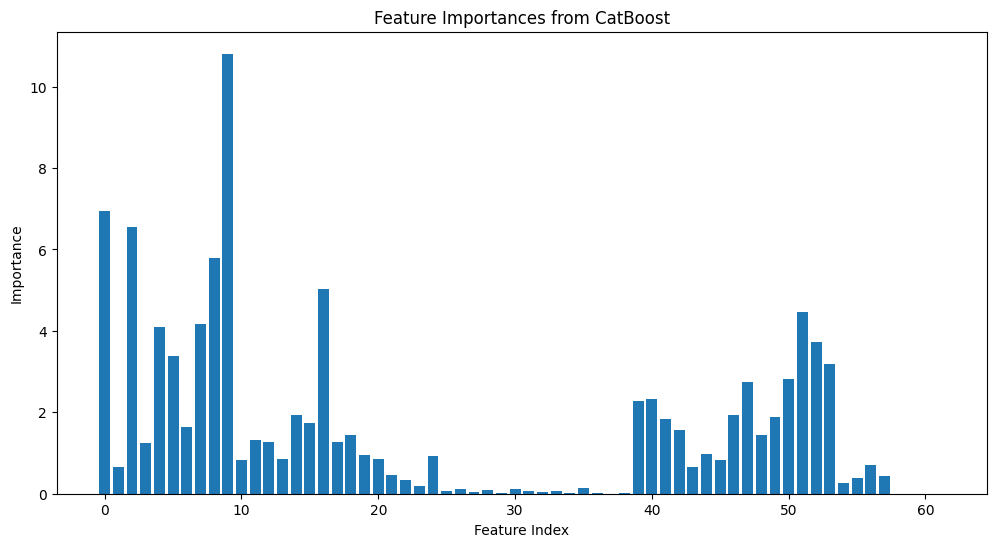

In [37]:
#### ======= Feature Importance Visualization (Optional) =======

import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from CatBoost
importances = model.get_feature_importance()

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(importances)), importances)
plt.title("Feature Importances from CatBoost")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()


##### Step 5 — Selecting Top 35 Most Important Features and creating new data frames 
To improve model performance and reduce noise, we rank all features by importance using CatBoost’s built-in `.get_feature_importance()` method.

- The top 35 features (out of 62) are selected based on their contribution to the model’s decisions.
- This subset is later used for model training and inference.

The selected features are printed and stored in a list `top_features` for downstream use.


Top 35 Features: ['f10', 'f3', 'f1', 'f9', 'f52', 'f5', 'f8', 'f17', 'f6', 'f53', 'f48', 'f54', 'f41', 'f16', 'f7', 'f50', 'f51', 'f47', 'f12', 'f13', 'f15', 'f40', 'f19', 'f42', 'f49', 'f4', 'f43', 'f18', 'f57', 'f14', 'f20', 'f46', 'f21', 'f45', 'f2']


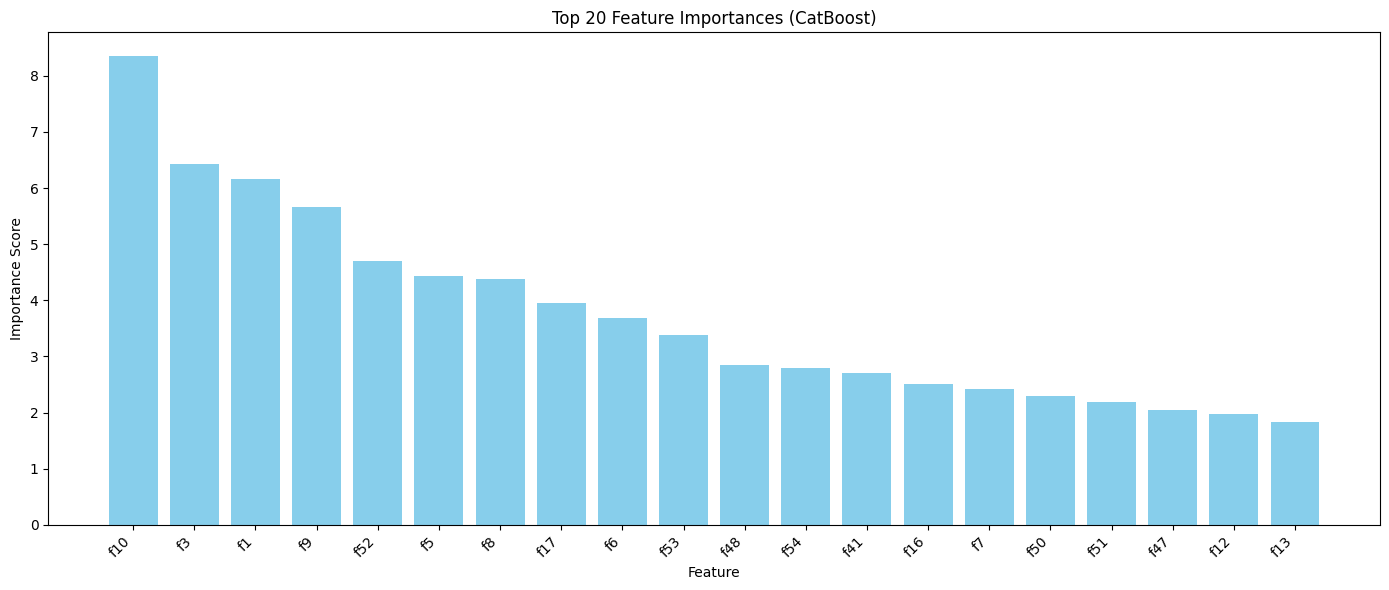

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

# === Step 1: Train the CatBoost model ===
cat_model = CatBoostClassifier(
    learning_rate=0.01,
    depth=6,
    iterations=300,
    verbose=0,
    random_state=42
)

# Fit on full feature set (not top-35)
cat_model.fit(X_train, y_train)

# === Step 2: Get feature importances ===
importances = cat_model.get_feature_importance()

# Generate feature names
feature_names = [f"f{i+1}" for i in range(X_train.shape[1])]

# Combine into a DataFrame and sort
feat_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Extract top 35 features
top_features = feat_df.head(35)["feature"].tolist()
print("Top 35 Features:", top_features)

# === Step 3: Visualize importances ===
plt.figure(figsize=(14, 6))
plt.bar(feat_df["feature"][:20], feat_df["importance"][:20], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Feature Importances (CatBoost)")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


In [39]:
# Convert full arrays to DataFrames with feature names
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Select top features only
X_train_top = X_train_df[top_features].values
X_test_top = X_test_df[top_features].values


In [ ]:
# from catboost import CatBoostClassifier
# from sklearn.metrics import accuracy_score, f1_score, classification_report

# # Try different manual class weight settings
# # Format: {class_0_weight, class_1_weight}


    
# model = CatBoostClassifier(
#     depth=6,
#     iterations=300,
#     learning_rate=0.01,
#     verbose=0,
#     random_state=42
# )

# model.fit(X_train_top, y_train)
# preds = model.predict(X_test_top)

# acc = accuracy_score(y_test, preds)
# f1 = f1_score(y_test, preds)

# print(f" Accuracy: {acc:.4f}, F1: {f1:.4f}")
# print(classification_report(y_test, preds))

# # Class weights were tested with multiple configurations.
# # Result: [1.0, 1.0] (equal weighting) gave the best performance.
# # Therefore, class_weights is omitted from the final model.


 Accuracy: 0.5672, F1: 0.6027
              precision    recall  f1-score   support

           0       0.53      0.52      0.52        31
           1       0.59      0.61      0.60        36

    accuracy                           0.57        67
   macro avg       0.56      0.56      0.56        67
weighted avg       0.57      0.57      0.57        67



### Step 6 — Final Ensemble Model Training and Evaluation

After tuning different weight combinations for the ensemble classifier, we finalize the best-performing setup using:

- **CatBoost** (as the most important model),
- **KNN** (k=2),
- **MLPClassifier** (1 hidden layer of 64 units).

We assign custom weights (`cat=1.9`, `knn=1.0`, `mlp=1.1`) based on prior experimentation and validate this ensemble’s performance on the test set.


In [ ]:
#Primary block for model training and evaluation
from itertools import product
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
import joblib

best_f1 = 0
best_weights = None
best_report = ""

# Only one combination as you requested
cw, kw, mw = 2, 1.0, 1.2

#  Re-initialize models each time to avoid reuse bugs
cat = CatBoostClassifier(
    learning_rate=0.005,
    depth=6,
    iterations=80,
    verbose=0,
    random_state=42
)

knn = KNeighborsClassifier(n_neighbors=2)

mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=42)

ensemble = VotingClassifier(
    estimators=[
        ('cat', cat),
        ('knn', knn),
        ('mlp', mlp)
    ],
    voting='soft',
    weights=[cw, kw, mw]
)

# Fit the ensemble model
ensemble.fit(X_train_top, y_train)

# Predict and evaluate
y_pred = ensemble.predict(X_test_top)

f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output results
print(f"\n Final Ensemble Results with Weights (cat={cw}, knn={kw}, mlp={mw})")
print(f"Ensemble Accuracy: {acc:.4f}")
print(f"Ensemble F1: {f1:.4f}")
print(report)



# Save the trained ensemble model
joblib.dump(ensemble, "best_voting_model.pkl")
print("✅ Ensemble model saved as 'best_voting_model.pkl'")



 Final Ensemble Results with Weights (cat=2, knn=1.0, mlp=1.2)
Ensemble Accuracy: 0.6418
Ensemble F1: 0.6667
              precision    recall  f1-score   support

           0       0.61      0.61      0.61        31
           1       0.67      0.67      0.67        36

    accuracy                           0.64        67
   macro avg       0.64      0.64      0.64        67
weighted avg       0.64      0.64      0.64        67

✅ Ensemble model saved as 'best_voting_model.pkl'


**Observations:**
- The ensemble demonstrates **balanced prediction** across both classes, with a slight edge in detecting true stories (class 1).
- Soft voting combines probability outputs from individual classifiers, offering **probabilistic interpretability** and **reduced variance**.
- The CatBoost model, being gradient-boosted, likely captures complex non-linear relationships, while KNN and MLP offer complementary decision boundaries.
- This configuration was selected after evaluating multiple weight combinations using `f1-score` as the key metric.
